In [5]:
import pandas as pd
import numpy as np

train_data=pd.read_csv('/users/fan/desktop/kaggle/bike_sharing/train.csv')
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


**探索数据**

season,holiday,workingday,weather变为category类型

拆分datetime

In [8]:
from datetime import datetime
train_data['date']=train_data.datetime.apply(lambda x:x.split()[0])
train_data['month']=train_data.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d').month)
train_data['hour']=train_data.datetime.apply(lambda x:x.split()[1].split(':')[0])
train_data['weekday']=train_data.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d').weekday())

category=['season','holiday','workingday','weather','month','hour','weekday']
for var in category:
    train_data[var]=train_data[var].astype('category')

train_data=train_data.drop('datetime',axis=1)

**处理缺失数据**
此数据集没有缺失数据

**离群值分析**

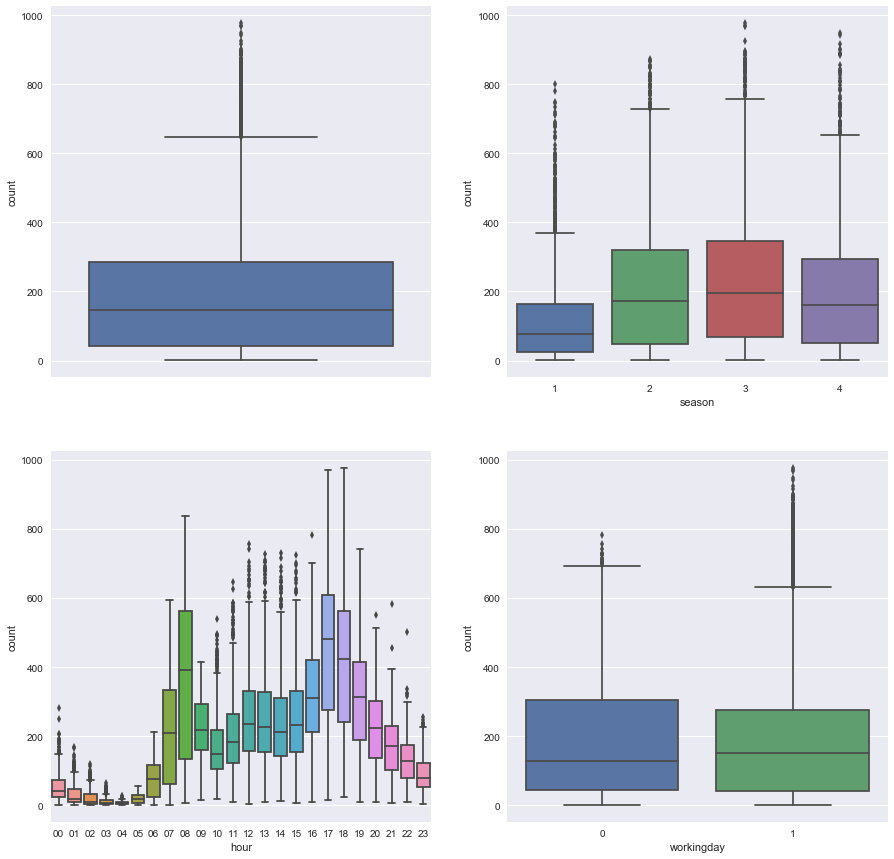

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
fig,axes=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,15)
sn.boxplot(data=train_data,y='count',orient='v',ax=axes[0][0])
sn.boxplot(data=train_data,y='count',x='season',ax=axes[0][1])
sn.boxplot(data=train_data,y='count',x='hour',ax=axes[1][0])
sn.boxplot(data=train_data,y='count',x='workingday',ax=axes[1][1])

season1(春季)租车人数较其他季节少

8点，17、18点租车人数较多

**删除离群值（大于3倍均方差）**

In [83]:
train_data_withoutoutliers=train_data[np.abs(train_data['count']-train_data['count'].mean())<=(3*train_data['count'].std())]
train_data_withoutoutliers.shape

(10739, 16)

**相关性分析**

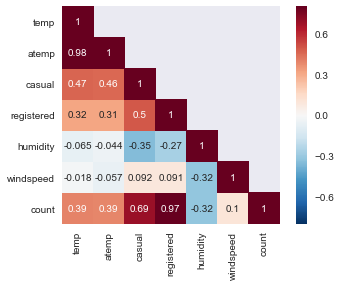

In [87]:
corrmatt=train_data[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask=np.array(corrmatt)
mask[np.tril_indices_from(mask)]=False
fig.ax=plt.subplot()
fig.set_size_inches(20,20)
sn.heatmap(corrmatt,mask=mask,vmax=.8,square=True,annot=True)

temp(温度）和atemp(体感温度)二者相关性很高，考虑只选取一个

temp与count正相关，humidity（湿度）与count负相关

windspeed（风速）几乎有count不相关

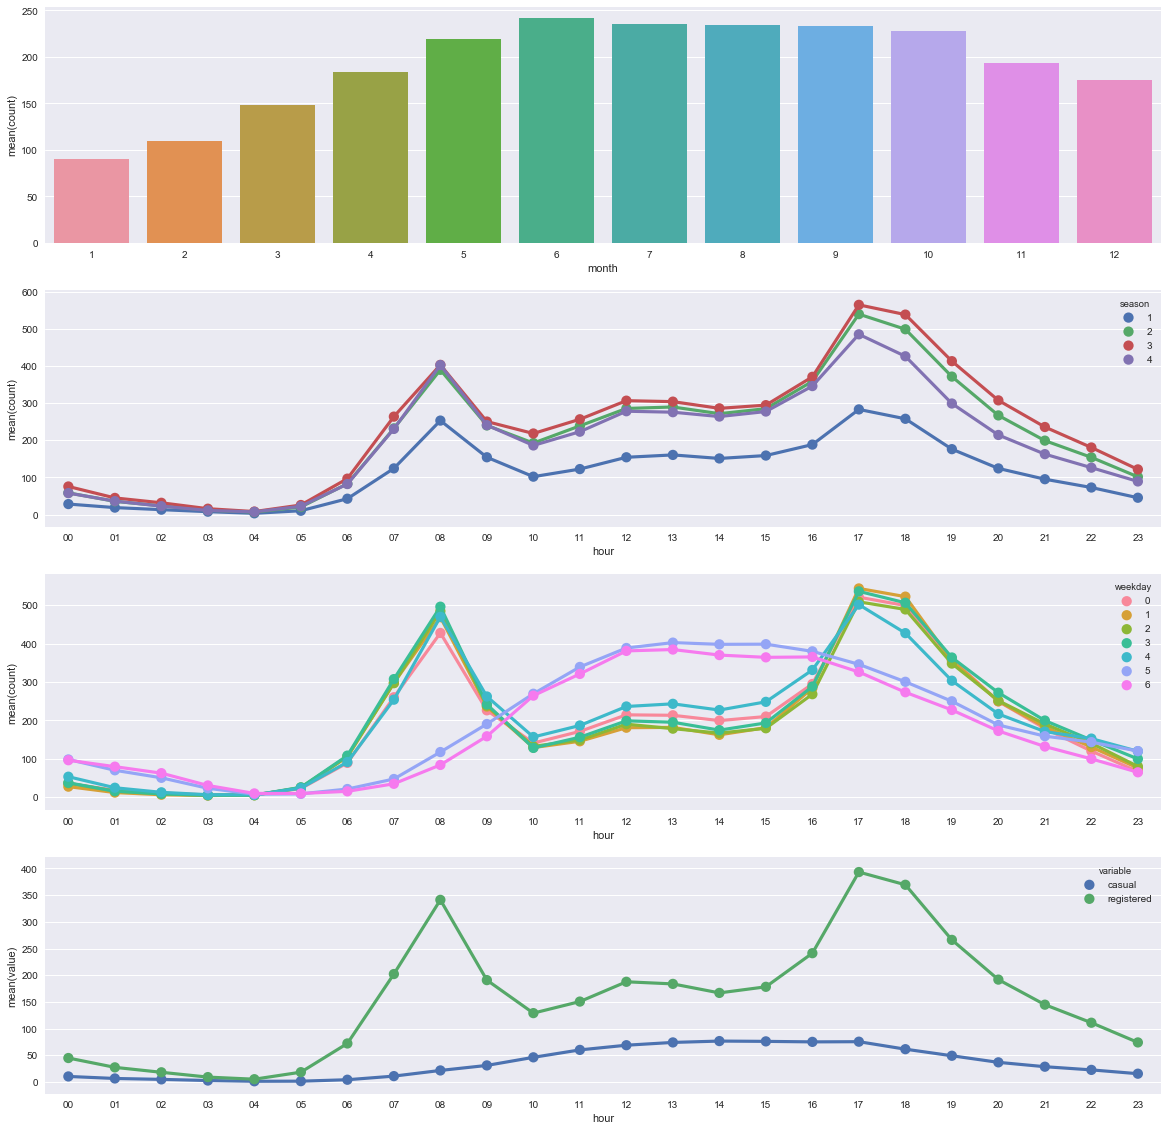

In [121]:
fig,axes=plt.subplots(nrows=4)
fig.set_size_inches(20,20)
month=pd.DataFrame(train_data.groupby('month')['count'].mean()).reset_index()
sn.barplot(data=month,x='month',y='count',ax=axes[0])

hour_season=train_data.groupby(['hour','season'])['count'].mean().reset_index()
sn.pointplot(data=hour_season,x='hour',y='count',hue='season',ax=axes[1])

hour_weekday=train_data.groupby(['hour','weekday'])['count'].mean().reset_index()
sn.pointplot(data=hour_weekday,x='hour',y='count',hue='weekday',ax=axes[2])

#pd.melt的用法
hour_user=pd.melt(train_data[['hour','casual','registered']],id_vars=['hour'],value_vars=['casual','registered'])
hour_user=hour_user.groupby(['hour','variable'])['value'].mean().reset_index()
sn.pointplot(data=hour_user,x='hour',y='value',hue='variable',ax=axes[3])


夏天秋天租车人数多

工作日租车高峰在7-9点，17-18点；周末租车集中在10-16点

注册用户租车时间更固定

**对测试数据做同样预处理**

In [20]:
test_data=pd.read_csv('/users/fan/desktop/kaggle/bike_sharing/test.csv')

test_data['date']=test_data.datetime.apply(lambda x:x.split()[0])
test_data['month']=test_data.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d').month)
test_data['hour']=test_data.datetime.apply(lambda x:x.split()[1].split(':')[0])
test_data['weekday']=test_data.date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d').weekday())

category=['season','holiday','workingday','weather','month','hour','weekday']
for var in category:
    test_data[var]=test_data[var].astype('category')

date=test_data['datetime']
test_data=test_data.drop('datetime',axis=1)
test_data.drop('date',axis=1,inplace=True)
train_data.drop('date',axis=1,inplace=True)

test_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,weekday
0,1,0,1,1,10.66,11.365,56,26.0027,1,00,3
1,1,0,1,1,10.66,13.635,56,0.0000,1,01,3
2,1,0,1,1,10.66,13.635,56,0.0000,1,02,3
3,1,0,1,1,10.66,12.880,56,11.0014,1,03,3
4,1,0,1,1,10.66,12.880,56,11.0014,1,04,3


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
month         10886 non-null category
hour          10886 non-null category
weekday       10886 non-null category
dtypes: category(7), float64(3), int64(4)
memory usage: 672.0 KB


**linear regression**

In [35]:
#评分方式 RMSLE
def rmsle(y_pred,y_true):
    log1=np.nan_to_num(np.array([np.log(v+1) for v in y_pred]))
    log2=np.nan_to_num(np.array([np.log(v+1) for v in y_true]))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))

In [38]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X=train_data.drop(['count','registered','casual'],axis=1)
y=train_data['count']

X_train,X_test,y_train,y_test=train_test_split(X,y)

lire=LinearRegression()
lire.fit(X_train,y_train)
y_pred=lire.predict(X_test)

rmsle(y_pred,y_test)


/Users/fan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


1.2421009868870432

In [ ]:
results=lire.predict(test_data)

In [32]:
submission=pd.DataFrame({'datetime':date,'count':[max(0,result) for result in results]})
submission.to_csv('/users/fan/desktop/kaggle/bike_sharing/bike_sharing_results.csv',index=False)